# Project: Demography meets Healthcare
# Author: Dilnaz Zeinolla & Zhumanova Zhanel
### Data Collection & Preparation SIS - Project




> To investigate how the number of hospitals relates to population size and the share of older adults (65+) across countries, using real data from the World Bank API and Wikipedia.





In [66]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

countries = [
    {"name": "Kazakhstan", "iso2": "KZ", "region": "Asia"},
    {"name": "Japan", "iso2": "JP", "region": "Asia"},
    {"name": "Germany", "iso2": "DE", "region": "Europe"},
    {"name": "France", "iso2": "FR", "region": "Europe"},
    {"name": "United States", "iso2": "US", "region": "North America"},
    {"name": "Canada", "iso2": "CA", "region": "North America"}
]

Obtaining data from the World Bank API

In [67]:
population_data = []

for country in countries:
    pop_url = f"https://api.worldbank.org/v2/country/{country['iso2']}/indicator/SP.POP.TOTL?format=json"
    elderly_url = f"https://api.worldbank.org/v2/country/{country['iso2']}/indicator/SP.POP.65UP.TO.ZS?format=json"

    pop_resp = requests.get(pop_url).json()
    elderly_resp = requests.get(elderly_url).json()

    pop_value = next(item["value"] for item in pop_resp[1] if item["value"] is not None)
    elderly_percent = next(item["value"] for item in elderly_resp[1] if item["value"] is not None)

    population_data.append({
        "Country": country["name"],
        "Region": country["region"],
        "Population": int(pop_value),
        "Elderly_percent": elderly_percent
    })

df_population = pd.DataFrame(population_data)
df_population


,Country,Region,Population,Elderly_percent
0,Kazakhstan,Asia,20592571,8.653235
1,Japan,Asia,123975371,29.780770
2,Germany,Europe,83510950,23.195587
3,France,Europe,68516699,22.146562
4,United States,North America,340110988,17.928730
5,Canada,North America,41288599,19.799591


Scraping Wikipedia

In [68]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

hospital_data = []

wiki_links = {
    "Kazakhstan": "https://en.wikipedia.org/wiki/List_of_hospitals_in_Kazakhstan",
    "Japan": "https://en.wikipedia.org/wiki/List_of_hospitals_in_Japan",
    "Germany": "https://en.wikipedia.org/wiki/List_of_hospitals_in_Germany",
    "France": "https://en.wikipedia.org/wiki/List_of_hospitals_in_France",
    "United States": "https://en.wikipedia.org/wiki/List_of_hospitals_in_the_United_States",
    "Canada": "https://en.wikipedia.org/wiki/List_of_hospitals_in_Canada"
}

headers = {"User-Agent": "Mozilla/5.0"}

for country, url in wiki_links.items():
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, "lxml")

    content = soup.find("div", {"class": "mw-parser-output"})
    if content:
        hospitals = len(content.find_all("li"))
    else:
        hospitals = 0

    hospital_data.append({"Country": country, "Hospitals": hospitals})

df_hospitals = pd.DataFrame(hospital_data)
df_hospitals


,Country,Hospitals
0,Kazakhstan,160
1,Japan,379
2,Germany,75
3,France,156
4,United States,415
5,Canada,712


Объединение и расчёт метрик

In [69]:
df = pd.merge(df_population, df_hospitals, on="Country")

df["Elderly_population"] = (df["Population"] * df["Elderly_percent"]) / 100
df["Hospitals_per_million"] = df["Hospitals"] / (df["Population"] / 1_000_000)
df["Hospitals_per_million_elderly"] = df["Hospitals"] / (df["Elderly_population"] / 1_000_000)

df




,Country,Region,Population,Elderly_percent,Hospitals,Elderly_population,Hospitals_per_million,Hospitals_per_million_elderly
0,Kazakhstan,Asia,20592571,8.653235,160,1.781923e+06,7.769792,89.790611
1,Japan,Asia,123975371,29.780770,379,3.692082e+07,3.057059,10.265211
2,Germany,Europe,83510950,23.195587,75,1.937086e+07,0.898086,3.871796
3,France,Europe,68516699,22.146562,156,1.517409e+07,2.276817,10.280680
4,United States,North America,340110988,17.928730,415,6.097758e+07,1.220190,6.805780
5,Canada,North America,41288599,19.799591,712,8.174974e+06,17.244470,87.095082


In [70]:

print(df.describe())

         Population  Elderly_percent   Hospitals  Elderly_population  \
count  6.000000e+00         6.000000    6.000000        6.000000e+00   
mean   1.129992e+08        20.250746  316.166667        2.373337e+07   
std    1.168160e+08         6.974025  236.052042        2.180487e+07   
min    2.059257e+07         8.653235   75.000000        1.781923e+06   
25%    4.809562e+07        18.396445  157.000000        9.924754e+06   
50%    7.601382e+07        20.973076  269.500000        1.727247e+07   
75%    1.138593e+08        22.933331  406.000000        3.253333e+07   
max    3.401110e+08        29.780770  712.000000        6.097758e+07   

       Hospitals_per_million  Hospitals_per_million_elderly  
count               6.000000                       6.000000  
mean                5.411069                      34.684860  
std                 6.306954                      41.718213  
min                 0.898086                       3.871796  
25%                 1.484347             

# Correlation (Population vs Hospitals)

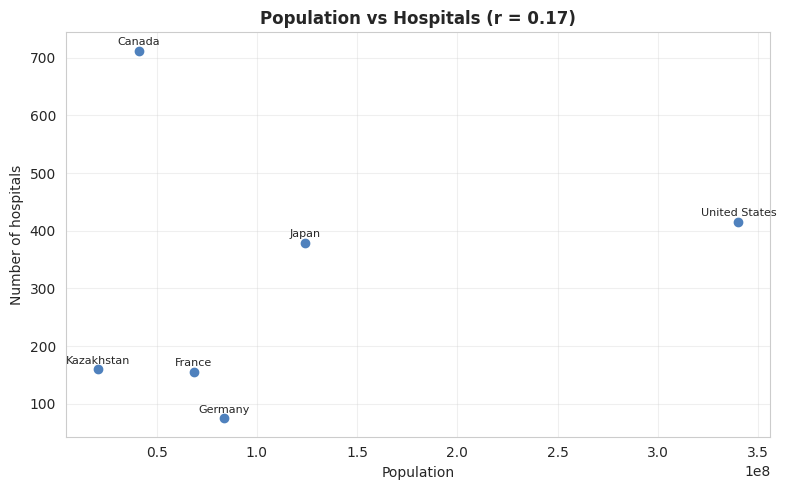

In [71]:
import matplotlib.ticker as ticker

plt.figure(figsize=(8,5))
plt.scatter(df["Population"], df["Hospitals"], color="#4F81BD")

for x, y, c in zip(df["Population"], df["Hospitals"], df["Country"]):
    plt.text(x, y+10, c, ha='center', fontsize=8)

plt.title(f"Population vs Hospitals (r = {df['Population'].corr(df['Hospitals']):.2f})", weight='bold')
plt.xlabel("Population")
plt.ylabel("Number of hospitals")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Active Healthcare Population 65+

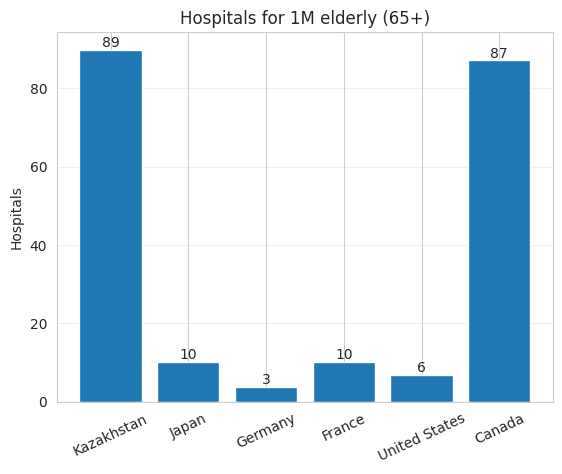

In [72]:
plt.bar(df["Country"], df["Hospitals_per_million_elderly"])
for x, y in zip(df["Country"], df["Hospitals_per_million_elderly"]):
    plt.text(x, y, int(y), ha='center', va='bottom')

plt.title("Hospitals for 1M elderly (65+)")
plt.ylabel("Hospitals")
plt.xticks(rotation=25)
plt.grid(axis='y', alpha=0.3)
plt.show()



# Regional Hospital Density

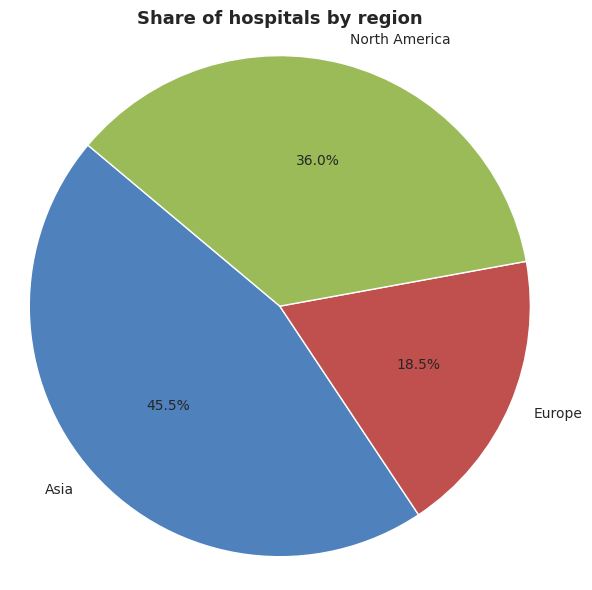

In [73]:
plt.figure(figsize=(6, 6))
plt.pie(
    region_stats["Hospitals_per_million"],
    labels=region_stats["Region"],
    autopct='%1.1f%%',
    startangle=140,
    colors=["#4F81BD", "#C0504D", "#9BBB59"],
    wedgeprops={'edgecolor': 'white'}
)

plt.title("Share of hospitals by region", fontsize=13, weight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()
